# Using KGFE to understand important features

Basically, given a list of genes/proteins/metabolites that are mapped onto SPOKE, we want to identify nodes on the graph that are in some way "similar" to the input nodes.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load genes

In [2]:
data = pd.read_excel('LC_mets_prots_V1_V2_Compare.xlsx')

In [3]:
data.head()

,ID,Lasso_CV,Name,UniProt,Protein,PubChem,Chembl_ID,KEGG
0,met10,-0.100203,"1,2,4-benzenetriol",NaN,NaN,10787.0,CHEMBL3092389,C02814
1,met1054,-0.052794,pyridine,NaN,NaN,1049.0,CHEMBL266158,C00747
2,met1073,0.051544,uric acid,NaN,NaN,1175.0,CHEMBL792,C00366
3,met1091,-0.054557,formononetin,NaN,NaN,5280378.0,CHEMBL242341,C00858
4,met142,0.025830,4-Hydroxyvalproic acid,NaN,NaN,134467.0,CHEMBL3706504,C16649


## 2. Load SPOKE

In [4]:
spoke_graph = kgfe.spoke_loader.load_spoke_networkx('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [5]:
# undirected version of spoke graph
spoke_graph_ud = nx.Graph(spoke_graph)

In [6]:
spoke_ids = list(sorted(spoke_graph_ud.nodes.keys()))

In [7]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Map proteins and metabolites to SPOKE nodes

In [8]:
len(names_to_ids)

617546

In [9]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')

In [10]:
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [11]:
high_prots = data[(data['Lasso_CV'] > 0) & (~data['UniProt'].isna())]['UniProt']
low_prots = data[(data['Lasso_CV'] < 0) & (~data['UniProt'].isna())]['UniProt']
high_chems = data[(data['Lasso_CV'] > 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']
low_chems = data[(data['Lasso_CV'] < 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']

In [12]:
high_prots_spoke_ids = [uniprot_to_ids[x] for x in high_prots]
low_prots_spoke_ids = [uniprot_to_ids[x] for x in low_prots]

In [132]:
high_prots_spoke_ids[:10]

[2117820,
 2117949,
 2117754,
 2146526,
 2117892,
 2119494,
 2117761,
 2118204,
 2118205,
 2149119]

In [13]:
high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]
low_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in low_chems if  x in chembl_to_ids]

Note: many chems were not able to be mapped onto SPOKE.

In [14]:
high_chems_spoke_ids

[('CHEMBL792', 1282230),
 ('CHEMBL78', 268338),
 ('CHEMBL1236395', 1497509),
 ('CHEMBL8165', 759937),
 ('CHEMBL1226', 1551766)]

In [15]:
low_chems_spoke_ids

[('CHEMBL3092389', 1051506),
 ('CHEMBL266158', 1529834),
 ('CHEMBL242341', 440588),
 ('CHEMBL454808', 1168062),
 ('CHEMBL449129', 1175855),
 ('CHEMBL228057', 5555),
 ('CHEMBL366563', 930796),
 ('CHEMBL1256480', 1328370),
 ('CHEMBL394875', 1843928)]

## Run hypergeometric/gene set analyses?

In [ ]:
# convert proteins to gene names


In [180]:
kgfe.explanations.hypgergeom_test(spoke_graph_ud, high_prots_spoke_ids, 

Signature:
kgfe.explanations.hypgergeom_test(
    graph,
    query_ids,
    query_category,
    query_universe=None,
)
Docstring:
Hypergeometric test:
N = number of nodes in the query category (OR the number of nodes in the query universe, if that's available),
n = number of nodes in the query set,
K = number of nodes connected to each given target node in the target category
k = number of nodes connected to the target node that are in the query set

Params:
    graph - a networkx graph
    query_ids - a list of IDs (NCBI Gene or PubChem), or a list of lists of ids
    query_category: 'Gene', 'Drug', 'SmallMolecule', 'Pathway'
    query_universe: either the universe of the query, or None if it's all nodes of the category in the graph. 

Returns:
    either a dict of hypergeometric p-values for node ids, or a list of dicts of hypergeometric p-values.
File:      ~/isb/kg_feature_engineering/src/kgfe/explanations.py
Type:      function

## 3. Run topic PageRank

In [16]:
high_prots_pr_results, high_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, high_prots_spoke_ids)

In [17]:
low_prots_pr_results, low_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, low_prots_spoke_ids)

In [18]:
high_chems_pr_results, high_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in high_chems_spoke_ids])

In [19]:
low_chems_pr_results, low_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in low_chems_spoke_ids])

In [20]:
pr_results_base = nx.pagerank(spoke_graph_ud)

pr_results_ratio is the ratio between the topic pagerank results and the baseline pagerank results - this indicates the increase in likelihood that the nodes will be visited in a personalized random walk, and is an attempt to control for nodes that are important globally.

In [21]:
pr_results_ratio = {x: high_prots_pr_results[x]/pr_results_base[x] for x in spoke_ids}

In [25]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

## 4. Plot PageRank results

In [27]:
import matplotlib.pyplot as plt

### Proteins with positive Lasso_CV scores

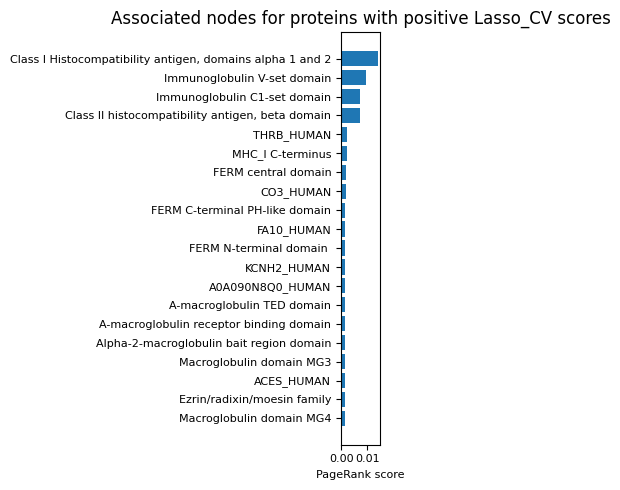

In [28]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_prots_top_nodes[:20][::-1]], [x['score'] for x in high_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

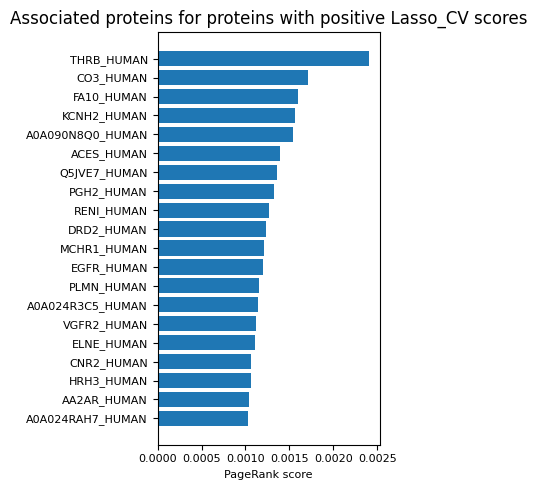

In [29]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

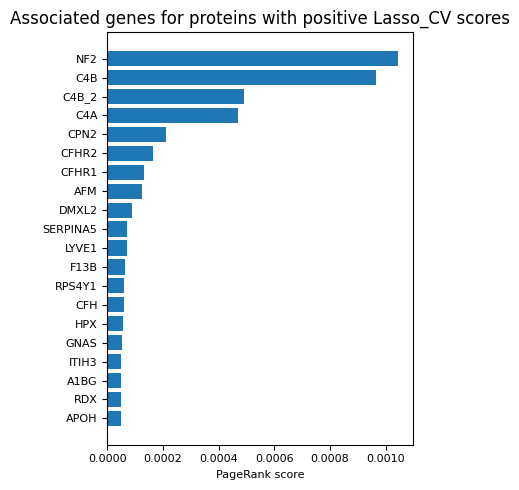

In [42]:
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_prots_top_genes[:20][::-1]], [x['score'] for x in high_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Proteins with negative Lasso_CV scores

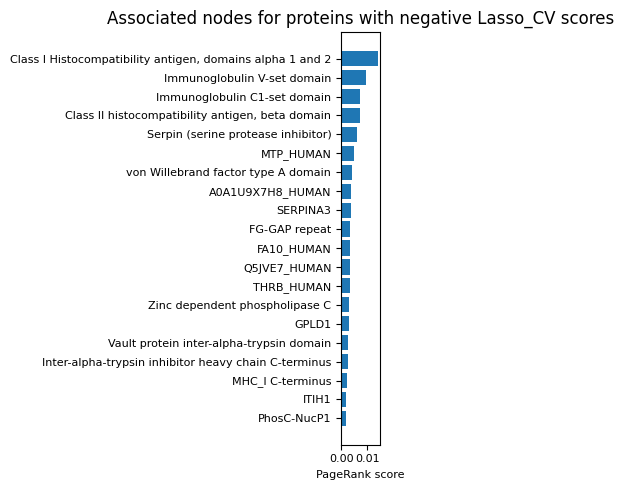

In [31]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_prots_top_nodes[:20][::-1]], [x['score'] for x in low_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

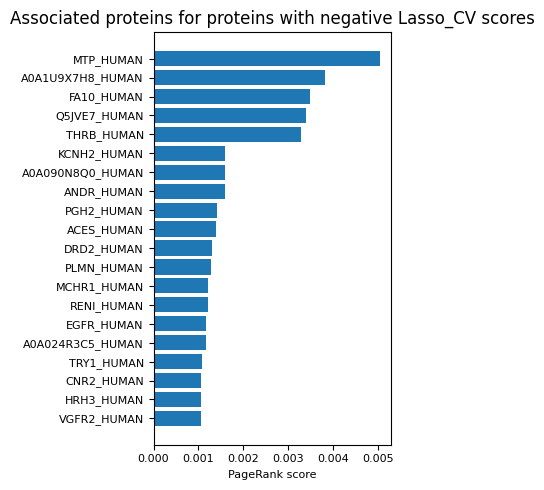

In [32]:
low_prots_top_proteins = [x for x in low_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_prots_top_proteins[:20][::-1]], [x['score'] for x in low_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

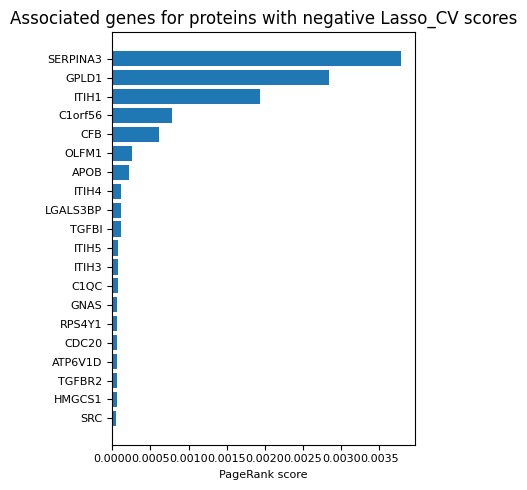

In [33]:
low_prots_top_genes = [x for x in low_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_prots_top_genes[:20][::-1]], [x['score'] for x in low_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with positive Lasso_CV scores

/tmp/ipykernel_1137424/888698534.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


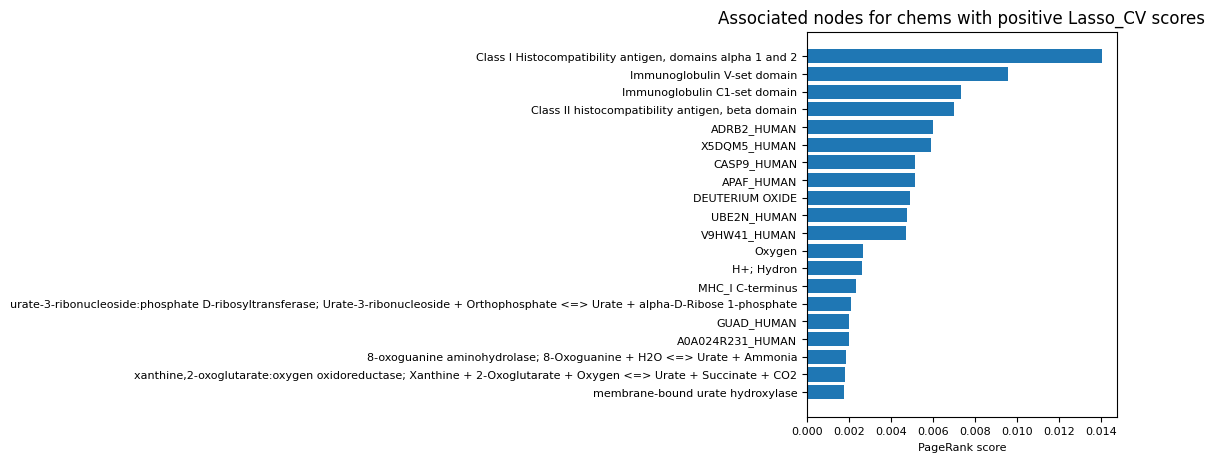

In [34]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_chems_top_nodes[:20][::-1]], [x['score'] for x in high_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

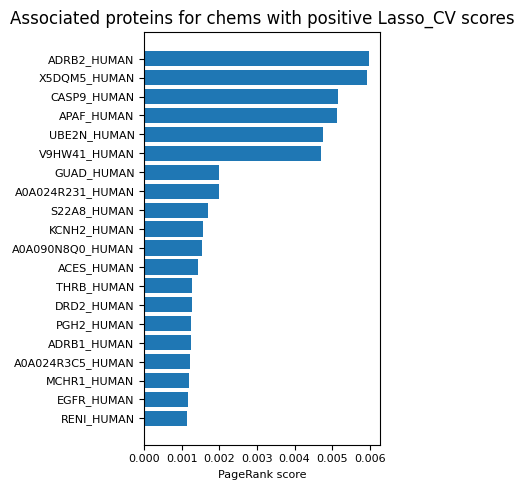

In [35]:
high_chems_top_proteins = [x for x in high_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_chems_top_proteins[:20][::-1]], [x['score'] for x in high_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

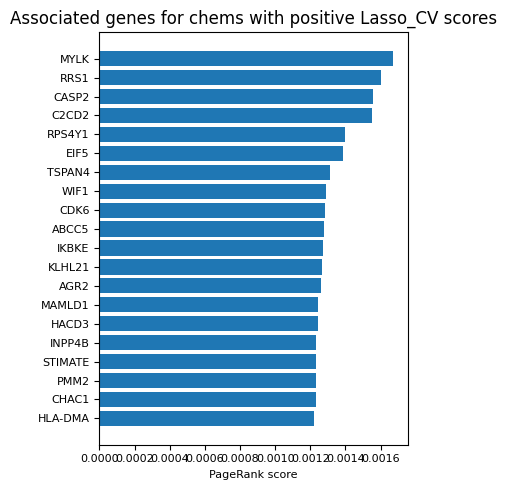

In [36]:
high_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_chems_top_genes[:20][::-1]], [x['score'] for x in high_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_1137424/1311438882.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


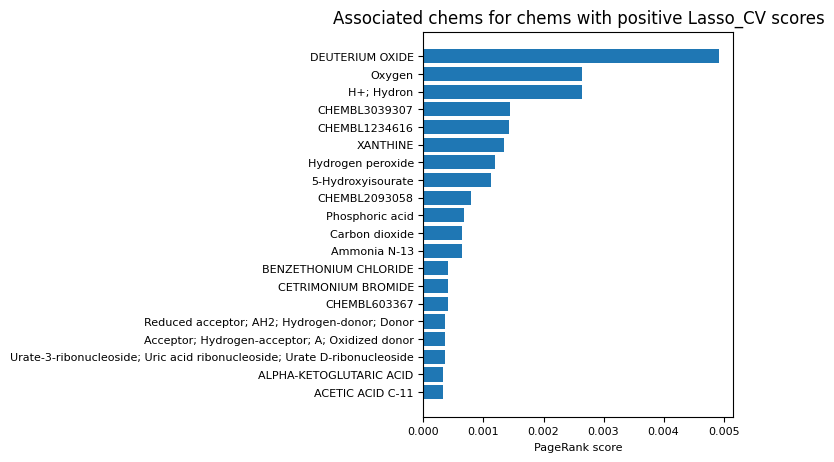

In [37]:
high_chems_top_chems = [x for x in high_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in high_chems_top_chems[:20][::-1]], [x['score'] for x in high_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with negative Lasso_CV scores

/tmp/ipykernel_1137424/3740405725.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


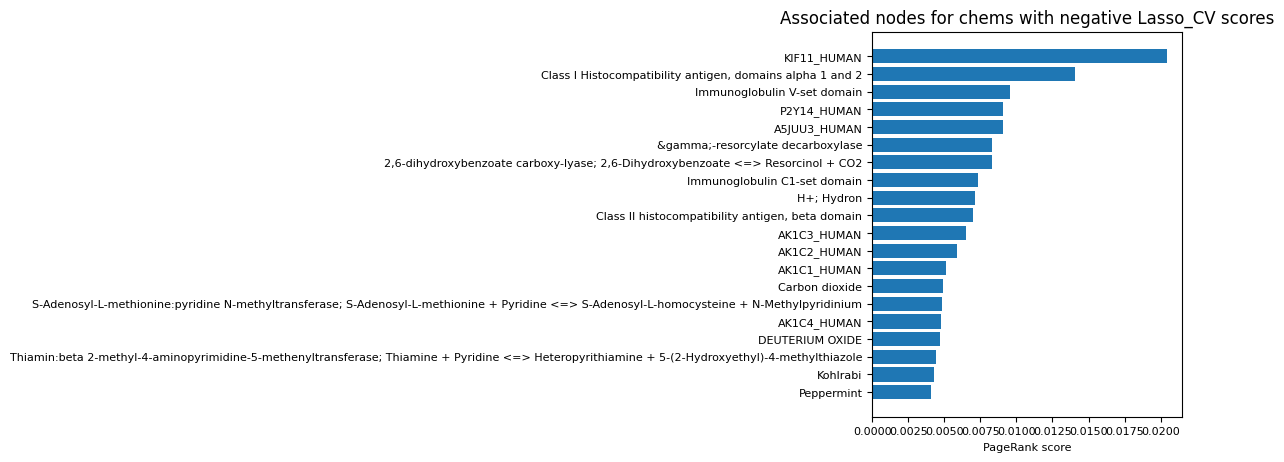

In [38]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_chems_top_nodes[:20][::-1]], [x['score'] for x in low_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

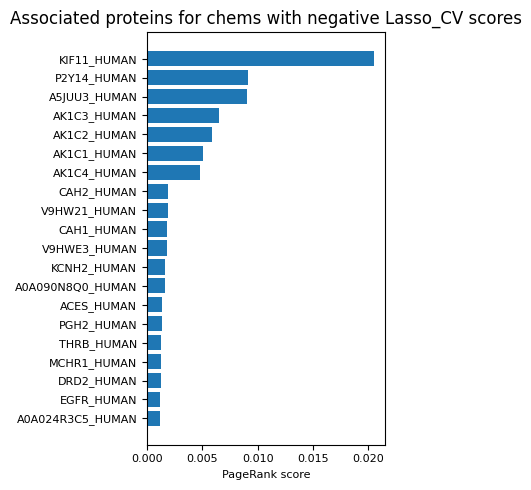

In [39]:
low_chems_top_proteins = [x for x in low_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_chems_top_proteins[:20][::-1]], [x['score'] for x in low_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

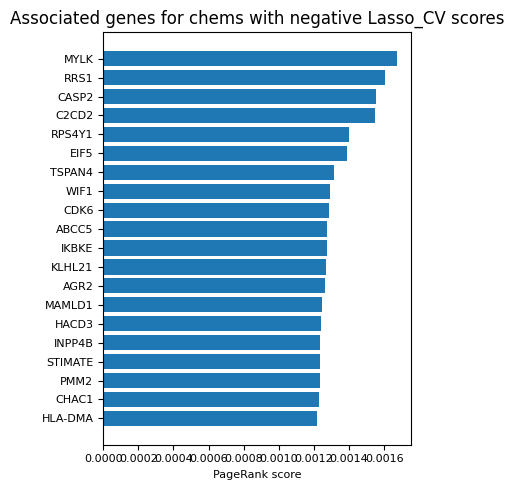

In [40]:
low_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_chems_top_genes[:20][::-1]], [x['score'] for x in low_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_1137424/641067761.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


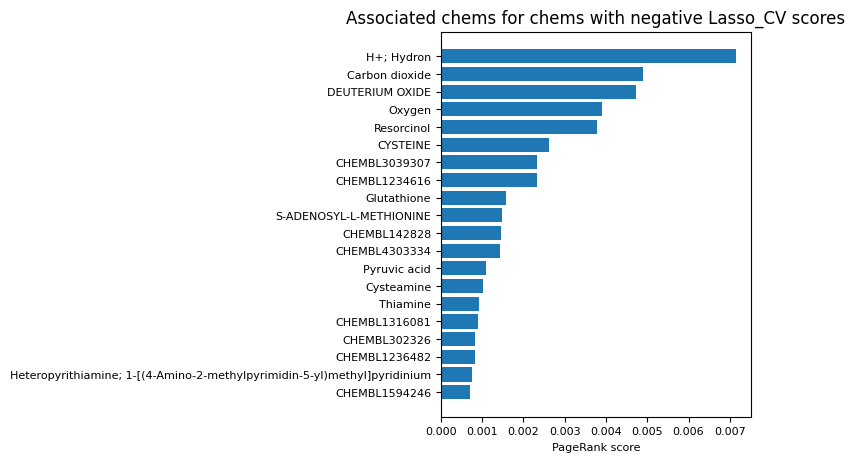

In [41]:
low_chems_top_chems = [x for x in low_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in low_chems_top_chems[:20][::-1]], [x['score'] for x in low_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

## 5. Get Steiner trees / subgraphs

In [44]:
protein_paths = nx.single_source_dijkstra(spoke_graph_ud, high_prots_spoke_ids[0])

In [46]:
protein_subgraph = nx.subgraph(spoke_graph, protein_paths[0].keys())
protein_subgraph_ud = nx.Graph(protein_subgraph)

In [172]:
high_protein_st = nx.approximation.steiner_tree(protein_subgraph_ud, high_prots_spoke_ids, method='mehlhorn')

is_in_set = {n: str(n in high_prots_spoke_ids) for n in high_protein_st.nodes}
high_protein_subgraph = nx.subgraph(protein_subgraph, high_protein_st)
nx.set_node_attributes(high_protein_subgraph, is_in_set, 'in_query')

In [173]:
low_protein_st = nx.approximation.steiner_tree(protein_subgraph_ud, low_prots_spoke_ids, method='mehlhorn')

is_in_set = {n: str(n in low_prots_spoke_ids) for n in low_protein_st.nodes}
low_protein_subgraph = nx.subgraph(protein_subgraph, low_protein_st)
nx.set_node_attributes(low_protein_subgraph, is_in_set, 'in_query')

In [138]:
#high_chems_spoke_ids = [x[1] for x in high_chems_spoke_ids]
chem_paths = nx.multi_source_dijkstra(spoke_graph_ud, high_chems_spoke_ids)
chem_subgraph = nx.subgraph(spoke_graph, chem_paths[0].keys())
chem_subgraph_ud = nx.Graph(chem_subgraph)

In [139]:
#low_chems_spoke_ids = [x[1] for x in low_chems_spoke_ids]


In [174]:
high_chems_st = nx.approximation.steiner_tree(chem_subgraph_ud, high_chems_spoke_ids, method='mehlhorn')

is_in_set = {n: str(n in high_chems_spoke_ids) for n in high_chems_st.nodes}
high_chems_subgraph = nx.subgraph(protein_subgraph, high_chems_st)
nx.set_node_attributes(high_chems_subgraph, is_in_set, 'in_query')

In [175]:
low_chems_st = nx.approximation.steiner_tree(chem_subgraph_ud, low_chems_spoke_ids, method='mehlhorn')

is_in_set = {n: str(n in low_chems_spoke_ids) for n in low_chems_st.nodes}
low_chems_subgraph = nx.subgraph(protein_subgraph, low_chems_st)
nx.set_node_attributes(low_chems_subgraph, is_in_set, 'in_query')

## Visualizing subgraphs

In [142]:
import ipycytoscape

In [183]:
graph_style = [{
                        'selector': 'node[name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query="True"]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [188]:
undirected = ipycytoscape.CytoscapeWidget()
undirected.graph.add_graph_from_networkx(top_protein_subgraph)
undirected.set_tooltip_source('name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [189]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [190]:
low_prots_graph = ipycytoscape.CytoscapeWidget()
low_prots_graph.graph.add_graph_from_networkx(low_protein_subgraph)
low_prots_graph.set_tooltip_source('name')
low_prots_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_prots_graph.set_style(graph_style)

In [191]:
display(low_prots_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [192]:
high_chems_graph = ipycytoscape.CytoscapeWidget()
high_chems_graph.graph.add_graph_from_networkx(high_chems_subgraph)
high_chems_graph.set_tooltip_source('name')
high_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
high_chems_graph.set_style(graph_style)

In [193]:
display(high_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [194]:
low_chems_graph = ipycytoscape.CytoscapeWidget()
low_chems_graph.graph.add_graph_from_networkx(low_chems_subgraph)
low_chems_graph.set_tooltip_source('name')
low_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_chems_graph.set_style(graph_style)

In [195]:
display(low_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…